## Survival analyses of genes using gene expression data (TCGA TNBC RNAseq data comprising 132 patients, separating into high and low gene expression with the median)

For questions, ask Ziming Zhao <ziming.zhao@jax.org> or Javad Noorbakhsh <Javad.Noorbakhsh@jax.org>

Codes updated January 2rd, 2018

In [2]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import statistics as st

def normalize_json(y): #From Sandeep
    """Converts a nested json string into a flat dict
    """
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name +  a + '.')
        elif type(x) is list:
            for a in x:
                flatten(a, name)
        else:
            out[str(name[:-1])] = x
    flatten(y)
    return out

def GetSurvivalData(FileName):
    json_data = json.load(open(FileName))
    
    json_df = pd.io.json.json_normalize(json_data)
    if json_df['diagnoses'].dropna().apply(len).apply(lambda x:x>1).any():
        raise Exception('diagnoses field has multiple values')
    
    if json_df['exposures'].dropna().apply(len).apply(lambda x:x>1).any():
        raise Exception('exposures field has multiple values')    

    df_clinical = pd.io.json.json_normalize([normalize_json(s) for s in json_data])

    df_survival = df_clinical[['diagnoses.submitter_id','diagnoses.days_to_death','diagnoses.days_to_last_follow_up','diagnoses.vital_status']].copy()
    df_survival.dropna(subset=['diagnoses.submitter_id'],inplace=True)
    df_survival['diagnoses.submitter_id'] = df_survival['diagnoses.submitter_id'].apply(lambda x:x[:-10])
    df_survival.set_index('diagnoses.submitter_id',inplace=True)
    df_survival['SurvivalDays'] = df_survival[['diagnoses.days_to_death','diagnoses.days_to_last_follow_up']].apply(lambda x:x[0] if ~np.isnan(x[0]) else x[1],axis=1)
    df_survival['Dead'] = (df_survival['diagnoses.vital_status']=='dead')
    df_survival.drop(['diagnoses.vital_status','diagnoses.days_to_death','diagnoses.days_to_last_follow_up'],axis=1,inplace=True)
    del df_survival.index.name
    return df_survival

In [7]:
#Get clinical data and gene expression data
SurvialFileName= '/Users/zhaoz/Dropbox/projects/GitHub/SurvivalAnalyses/brca_clinical.json'
GeneExpressionFilename = '/Users/zhaoz/Dropbox/projects/GitHub/SurvivalAnalyses/TNBC_TCGA_132_RNAseq.csv'
df = GetSurvivalData(SurvialFileName)
df1 = pd.read_csv(GeneExpressionFilename,sep=',',index_col=0).T
newlst = []
df1.index
for i in (df1.index):
    newlst.append(i[:-16])
df1.index = newlst
df1.index

#Combine clinical data and gene expression data for the interested genes
df3 = pd.concat([df,df1[['CCNE1','TPX2', 'TRA2B']]], axis = 1, join = 'inner')

In [8]:
def SurvivalCurve(Genename):    

    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()

    import matplotlib.pylab as pl
    dem = df3[Genename] > st.median(df3[Genename])

    ax = pl.subplot(111)

    T = df3["SurvivalDays"]
    C = df3["Dead"]

    kmf.fit(T[dem], event_observed=C[dem] ,label='High')
    kmf.plot(ax=ax,show_censors=True,color='orange')

    kmf.fit(T[~dem], event_observed=C[~dem] ,label='Low')
    kmf.plot(ax=ax,show_censors=True,color='lightblue')

    from lifelines.statistics import logrank_test


    results = logrank_test(T[dem], T[~dem], C[dem], C[~dem], alpha=.95 )
    pl.title('%s\np-value = %.2e'%(Genename,results.p_value))

    pl.legend(loc='lower left')

## Survival analyses of genes "CCNE1","TPX2","TRA2B" using gene expression data (TCGA TNBC RNAseq data comprising 132 patients, separating into high and low gene expression with the median; P-value was labled on the top)

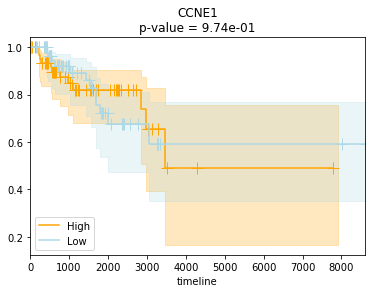

In [9]:
SurvivalCurve('CCNE1')

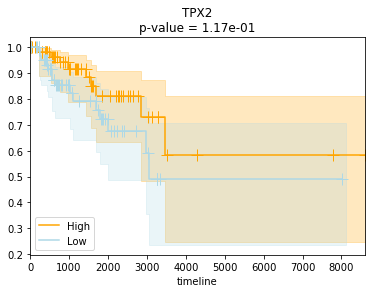

In [10]:
SurvivalCurve('TPX2')

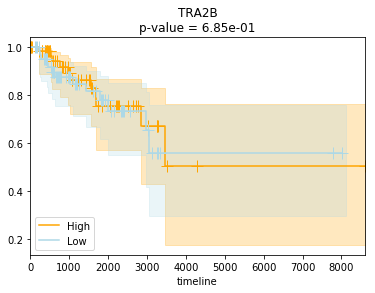

In [11]:
SurvivalCurve('TRA2B')